# Context Comparison Analysis: Full Context vs Essay Only

This notebook analyzes the overlap of confidence intervals for QWK scores between different contexts (full_context vs essay_only) while keeping the model and guideline fixed.

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Load the data
df = pd.read_csv('data/ci_wf1_prompt_type.csv', header=[0, 1])

# Clean up the column names
# The first three columns are single-level (Model, Guideline, Context)
# The rest are multi-level with competencies
df.columns = ['_'.join(col).strip('_') if col[1] != '' else col[0] 
              for col in df.columns.values]

df.rename(columns={"Unnamed: 0_level_0_Model": "Model", 
                   " _Guideline": "Guideline",
                   "Unnamed: 1_level_0_Guideline": "Guideline", 
                   " _Context": "Context",
                   "Unnamed: 2_level_0_Context": "Context"}, inplace=True)
SUFFIX = "W"

# Display the structure
print("Data shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
df.head()

Data shape: (18, 13)

Column names:
['Model', 'Guideline', 'Context', 'C1_W_low', 'C1_W_up', 'C2_W_low', 'C2_W_up', 'C3_W_low', 'C3_W_up', 'C4_W_low', 'C4_W_up', 'C5_W_low', 'C5_W_up']


,Model,Guideline,Context,C1_W_low,C1_W_up,C2_W_low,C2_W_up,C3_W_low,C3_W_up,C4_W_low,C4_W_up,C5_W_low,C5_W_up
0,DeepseekR1,Mixed,essay_only,0.17,0.33,0.01,0.10,0.12,0.26,0.16,0.33,0.25,0.42
1,DeepseekR1,Student,essay_only,0.10,0.24,0.17,0.33,0.25,0.41,0.31,0.48,0.34,0.51
2,DeepseekR1,Grader,essay_only,0.06,0.19,0.00,0.04,0.24,0.40,0.44,0.61,0.30,0.47
3,DeepseekR1,Mixed,full_context,0.01,0.11,0.31,0.50,0.22,0.37,0.37,0.54,0.28,0.46
4,DeepseekR1,Student,full_context,0.02,0.11,0.26,0.44,0.38,0.55,0.28,0.45,0.32,0.49


In [3]:
def plot_context_comparison(df, model_name, guideline_type, competency, suffix):
    """
    Plot confidence intervals comparing contexts (full_context vs essay_only) 
    for a specific model, guideline, and competency.
    """
    # Filter data for the specified model and guideline
    filtered_df = df[(df['Model'] == model_name) & (df['Guideline'] == guideline_type)]
    
    if filtered_df.empty:
        print(f"No data found for model '{model_name}' with guideline '{guideline_type}'")
        return
    
    # Get column names for the specified competency
    low_col = f'{competency}_{suffix}_low'
    up_col = f'{competency}_{suffix}_up'
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define colors for each context
    colors = {'essay_only': 'darkblue', 'full_context': 'darkred'}
    
    # Plot each context
    y_positions = []
    for i, (idx, row) in enumerate(filtered_df.iterrows()):
        context = row['Context']
        low = row[low_col]
        up = row[up_col]
        mid = (low + up) / 2
        
        # Plot the confidence interval
        ax.plot([low, up], [i, i], 'o-', color=colors[context], 
                linewidth=3, markersize=8, label=context if i == 0 else "")
        
        # Add the midpoint
        ax.plot(mid, i, 'o', color='black', markersize=6)
        
        # Add text labels
        ax.text(up + 0.02, i, f'{context}: [{low:.2f}, {up:.2f}]', 
                verticalalignment='center', fontsize=10)
        
        y_positions.append(i)
    
    # Customize the plot
    ax.set_yticks(y_positions)
    ax.set_yticklabels(filtered_df['Context'])
    ax.set_xlabel(f'{suffix} Score', fontsize=12)
    ax.set_ylabel('Context', fontsize=12)
    ax.set_title(f'Context Comparison for {model_name} - {guideline_type} - {competency}', 
                 fontsize=14, fontweight='bold')
    
    # Add grid
    ax.grid(True, axis='x', alpha=0.3)
    
    # Set x-axis limits
    ax.set_xlim(-0.2, 1.0)
    
    # Add reference lines
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
    
    # Check for overlaps and add annotations
    check_context_overlaps(filtered_df, low_col, up_col, ax)
    
    plt.tight_layout()
    plt.show()

In [4]:
def check_context_overlaps(filtered_df, low_col, up_col, ax):
    """
    Check for overlaps between context confidence intervals and add annotations.
    """
    contexts = filtered_df['Context'].tolist()
    intervals = [(row[low_col], row[up_col]) for _, row in filtered_df.iterrows()]
    
    # Check if there are exactly two contexts to compare
    if len(intervals) == 2:
        # Check if intervals overlap
        if (intervals[0][0] <= intervals[1][1] and intervals[1][0] <= intervals[0][1]):
            overlap_text = f"Contexts overlap: {contexts[0]} and {contexts[1]}"
            ax.text(0.02, 0.98, overlap_text, transform=ax.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
        else:
            ax.text(0.02, 0.98, "No overlap between contexts", transform=ax.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
            
            # Calculate the gap between intervals
            if intervals[0][1] < intervals[1][0]:
                gap = intervals[1][0] - intervals[0][1]
                ax.text(0.02, 0.90, f"Gap between intervals: {gap:.3f}", transform=ax.transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
            elif intervals[1][1] < intervals[0][0]:
                gap = intervals[0][0] - intervals[1][1]
                ax.text(0.02, 0.90, f"Gap between intervals: {gap:.3f}", transform=ax.transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

In [5]:
def analyze_model_guideline(df, model_name, guideline_type, suffix):
    """
    Analyze all competencies comparing contexts for a given model and guideline combination.
    """
    competencies = ['C1', 'C2', 'C3', 'C4', 'C5']
    
    print(f"\n{'='*60}")
    print(f"Context Comparison for Model: {model_name}, Guideline: {guideline_type}")
    print(f"{'='*60}\n")
    
    for comp in competencies:
        plot_context_comparison(df, model_name, guideline_type, comp, suffix)

## Example Analysis: DeepseekR1 with Mixed guideline

Let's compare the confidence intervals between essay_only and full_context for DeepseekR1 model with Mixed guideline across all competencies.


Context Comparison for Model: DeepseekR1, Guideline: Mixed



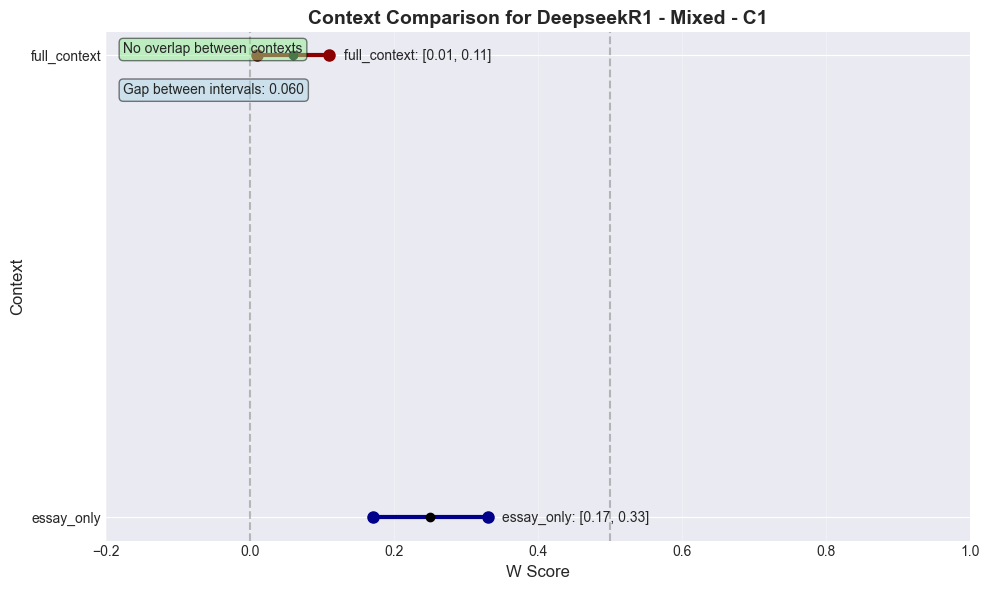

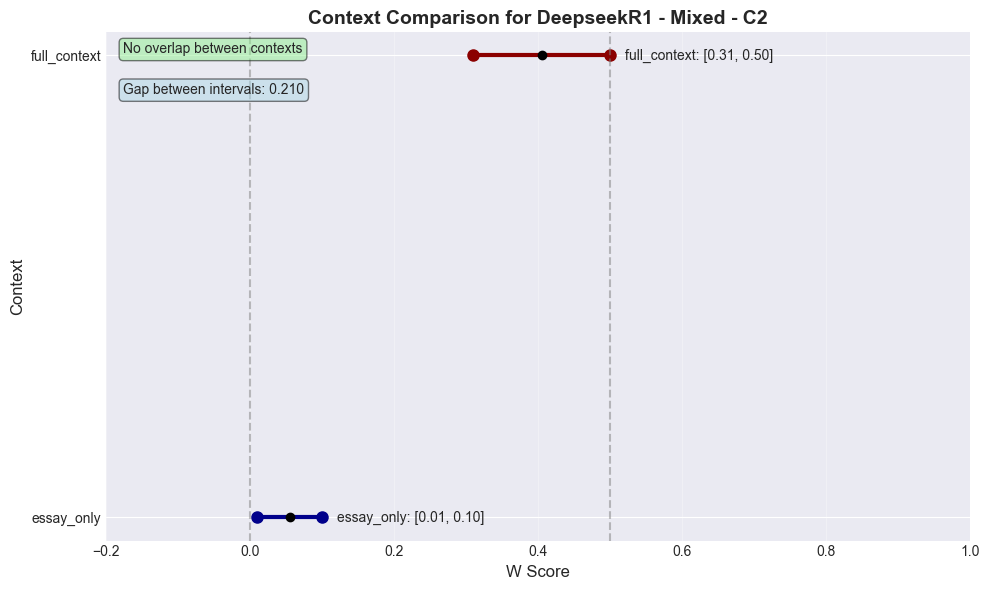

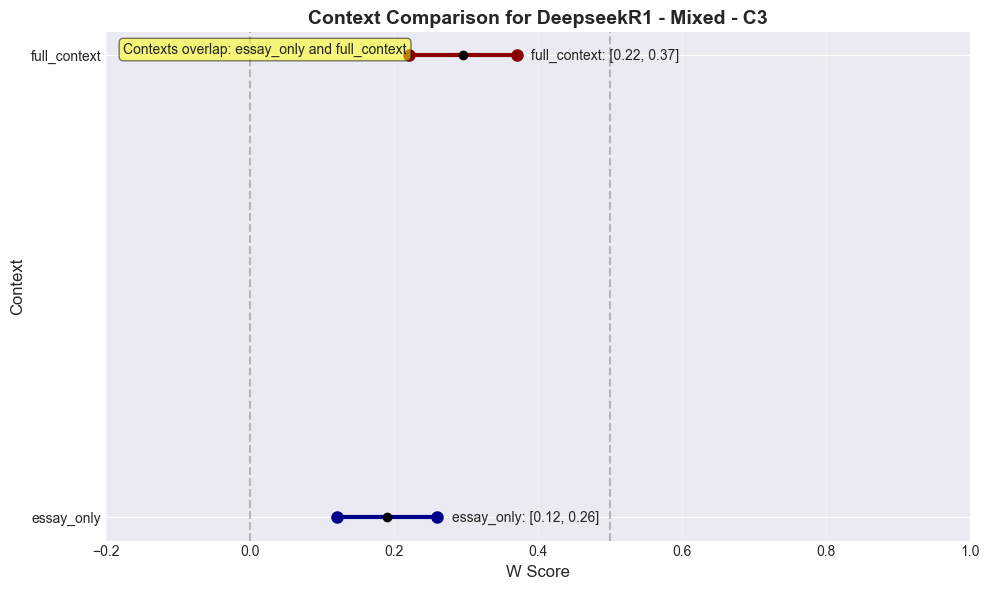

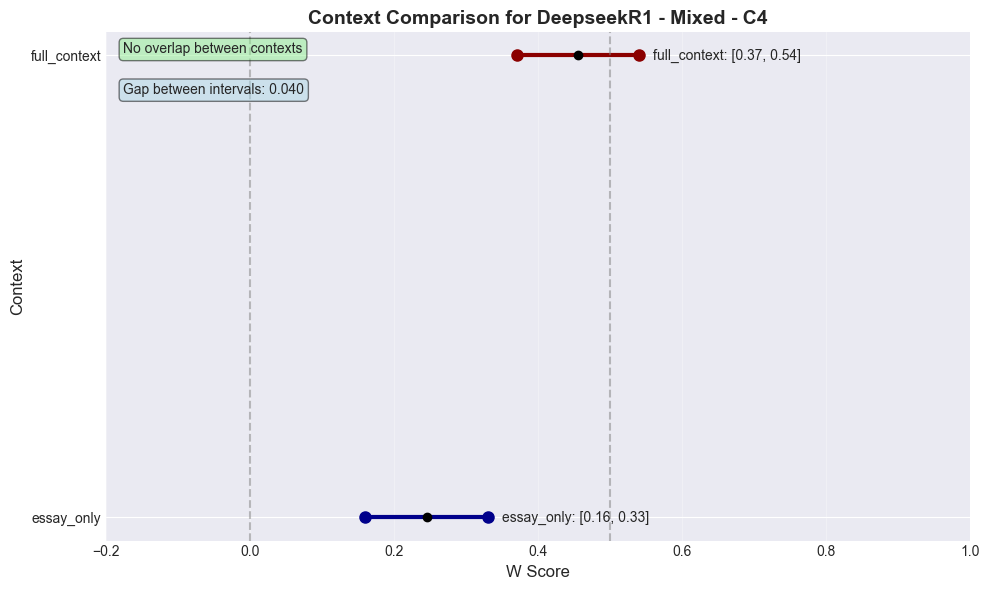

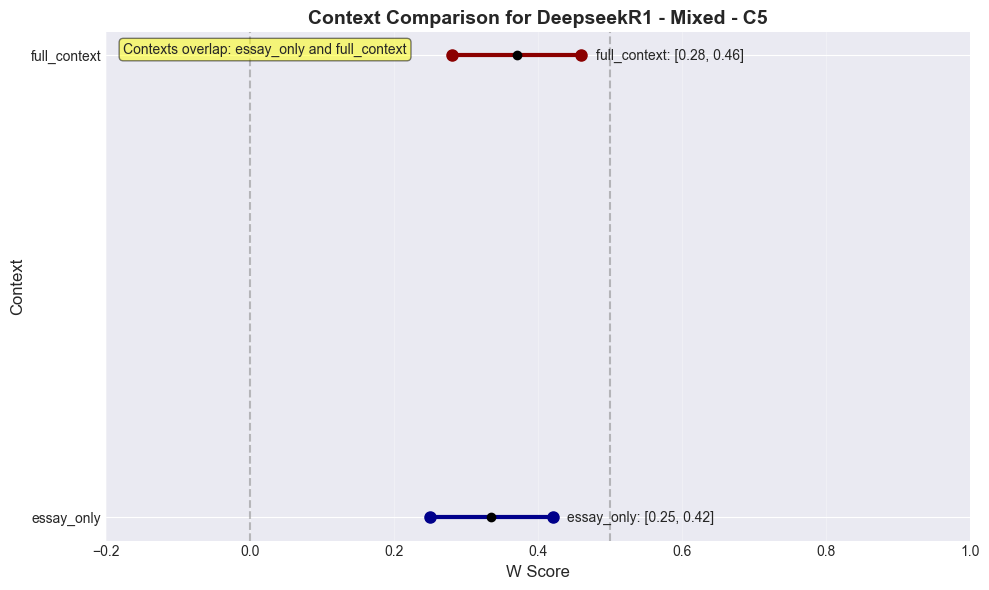

In [6]:
# Analyze DeepseekR1 with Mixed guideline
analyze_model_guideline(df, 'DeepseekR1', 'Mixed', SUFFIX)

## Interactive Analysis

You can analyze any model-guideline combination by specifying the parameters below.

In [7]:
# Get unique values for reference
print("Available models:", df['Model'].unique().tolist())
print("Available guidelines:", df['Guideline'].unique().tolist())
print("Available contexts:", df['Context'].unique().tolist())

Available models: ['DeepseekR1', 'GPT4o', 'Sabiá3']
Available guidelines: ['Mixed', 'Student', 'Grader']
Available contexts: ['essay_only', 'full_context']



Context Comparison for Model: GPT4o, Guideline: Student



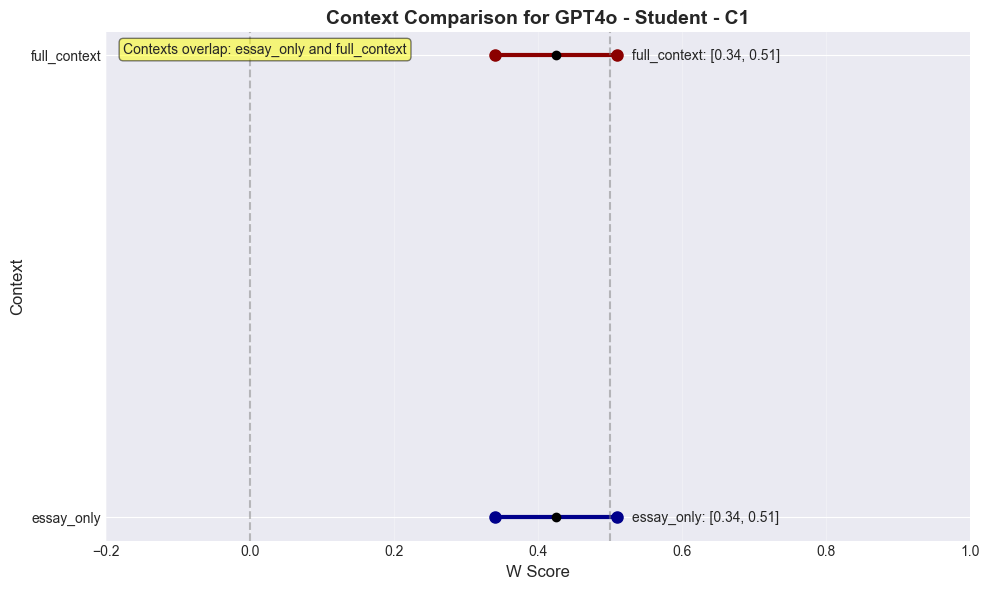

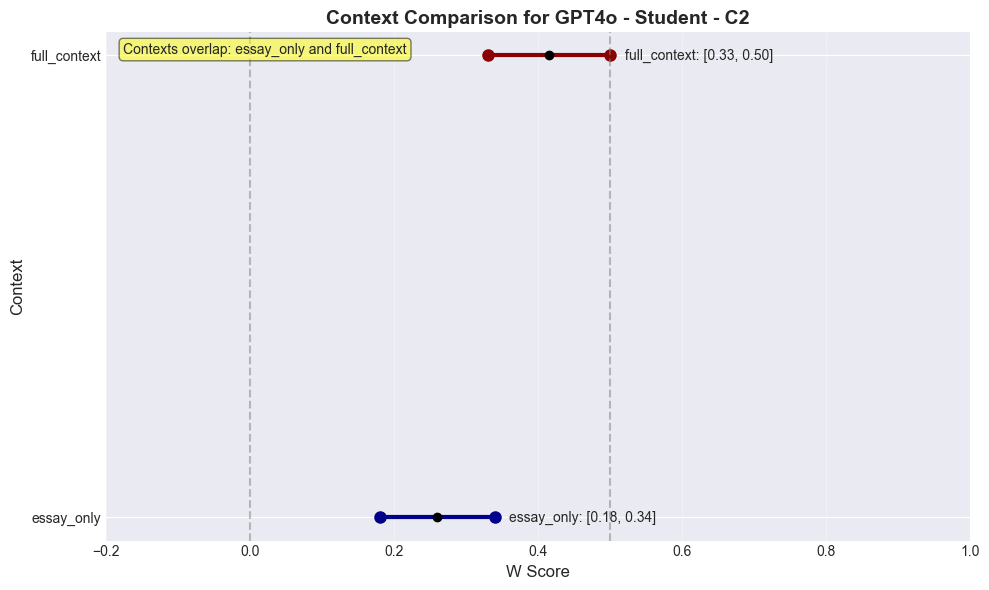

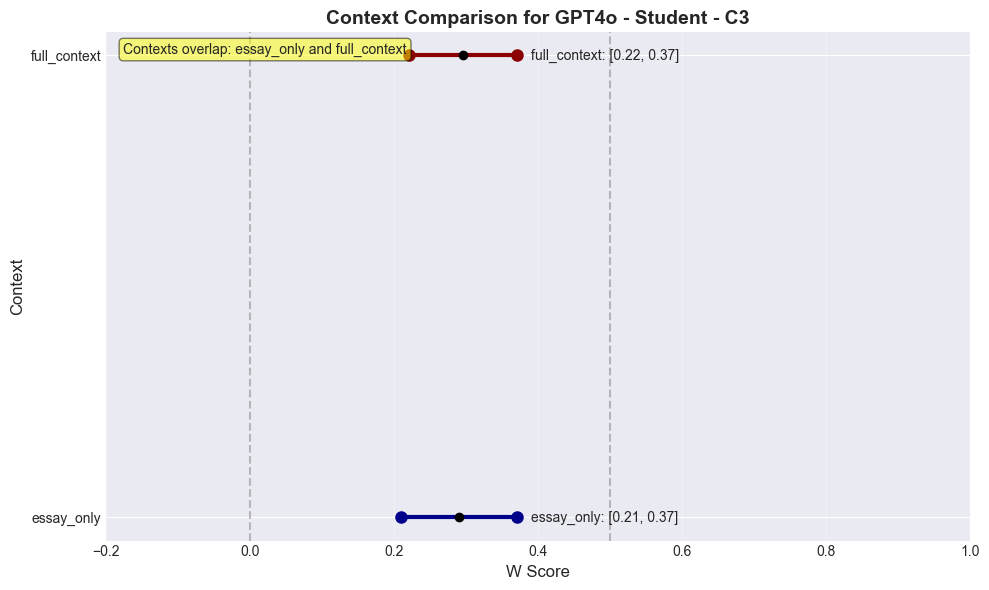

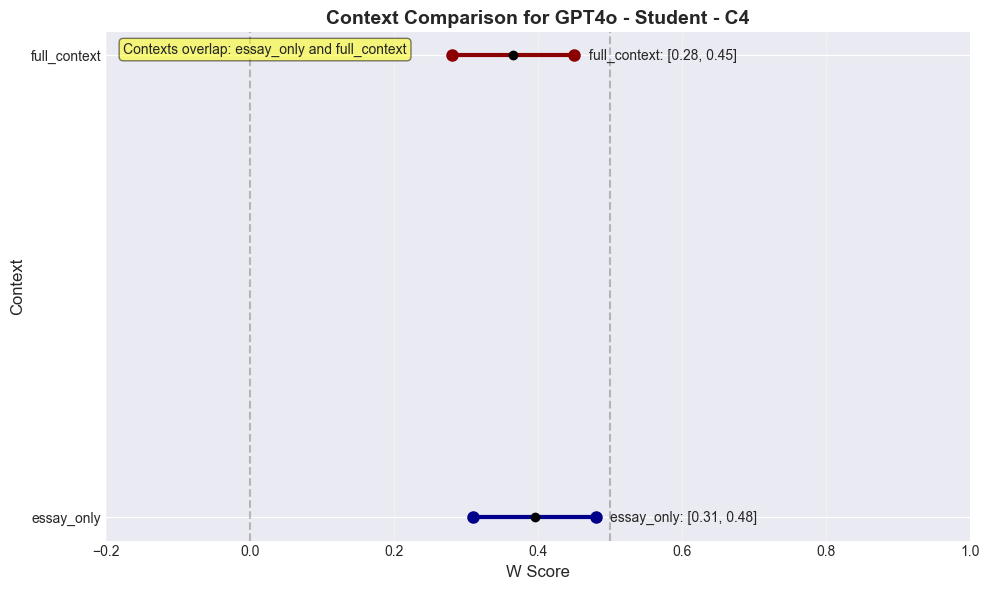

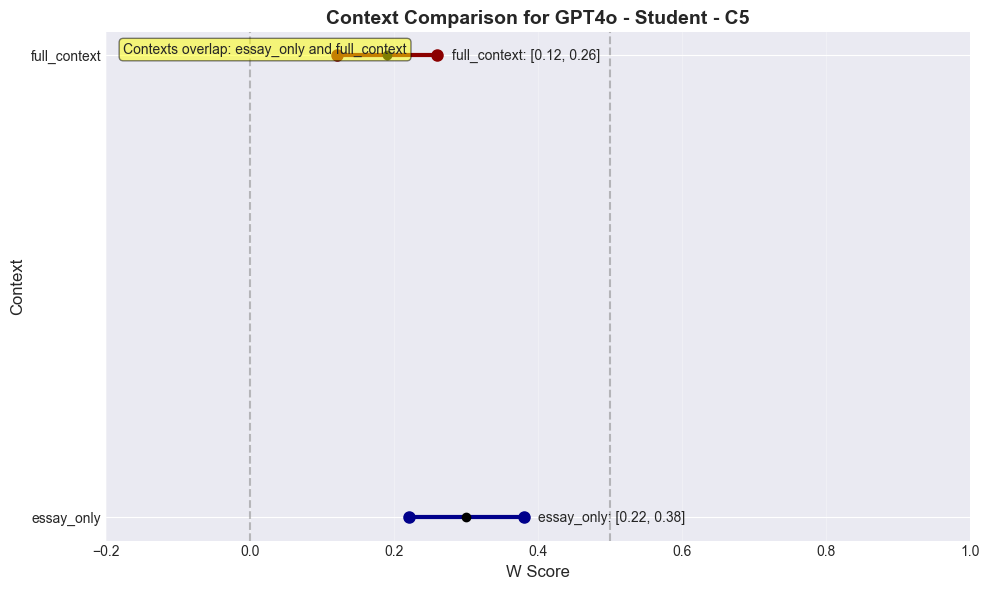

In [8]:
# Example: Analyze another combination
# Change these parameters to analyze different combinations
model_to_analyze = 'GPT4o'
guideline_to_analyze = 'Student'

analyze_model_guideline(df, model_to_analyze, guideline_to_analyze, SUFFIX)

## Comprehensive Analysis: All Guidelines for a Model

Let's analyze all guidelines for a specific model to see how context affects each guideline type.

In [9]:
def analyze_all_guidelines_for_model(df, model_name, suffix):
    """
    Analyze all guidelines for a given model, comparing contexts.
    """
    guidelines = df['Guideline'].unique()
    
    print(f"\n{'='*70}")
    print(f"COMPREHENSIVE ANALYSIS FOR MODEL: {model_name}")
    print(f"{'='*70}")
    
    for guideline in guidelines:
        analyze_model_guideline(df, model_name, guideline, suffix)


COMPREHENSIVE ANALYSIS FOR MODEL: Sabiá3

Context Comparison for Model: Sabiá3, Guideline: Mixed



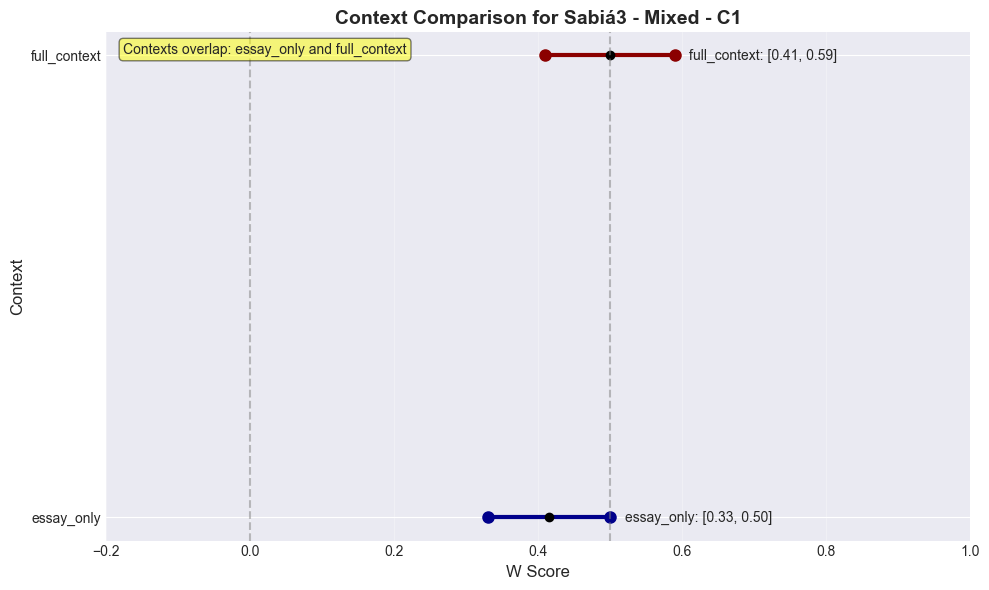

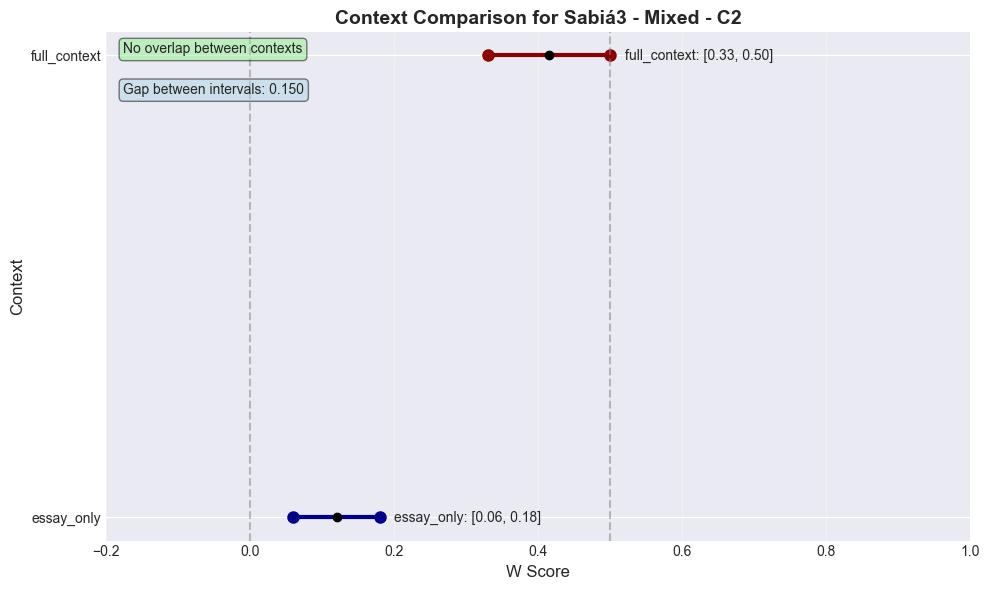

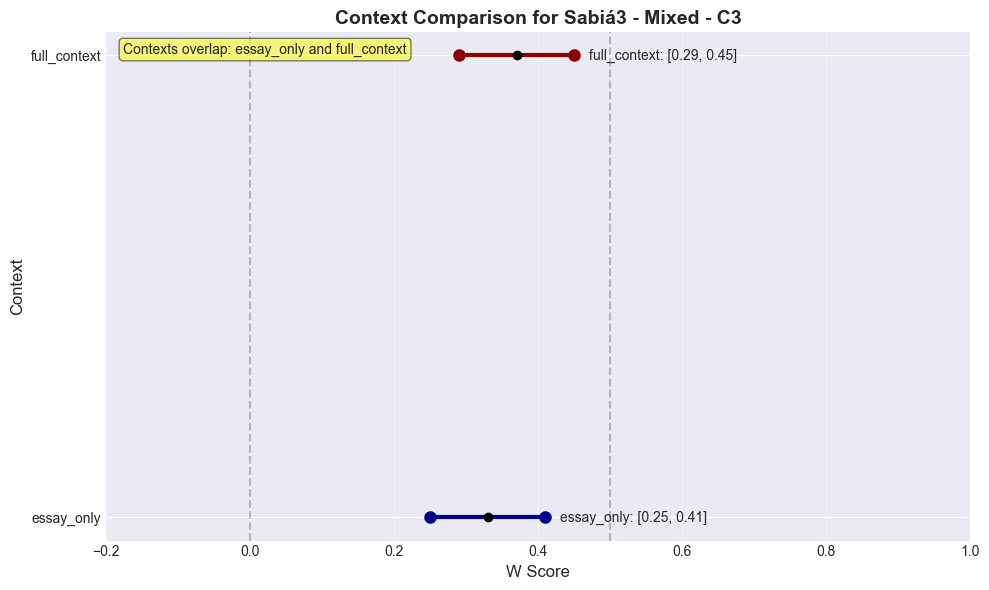

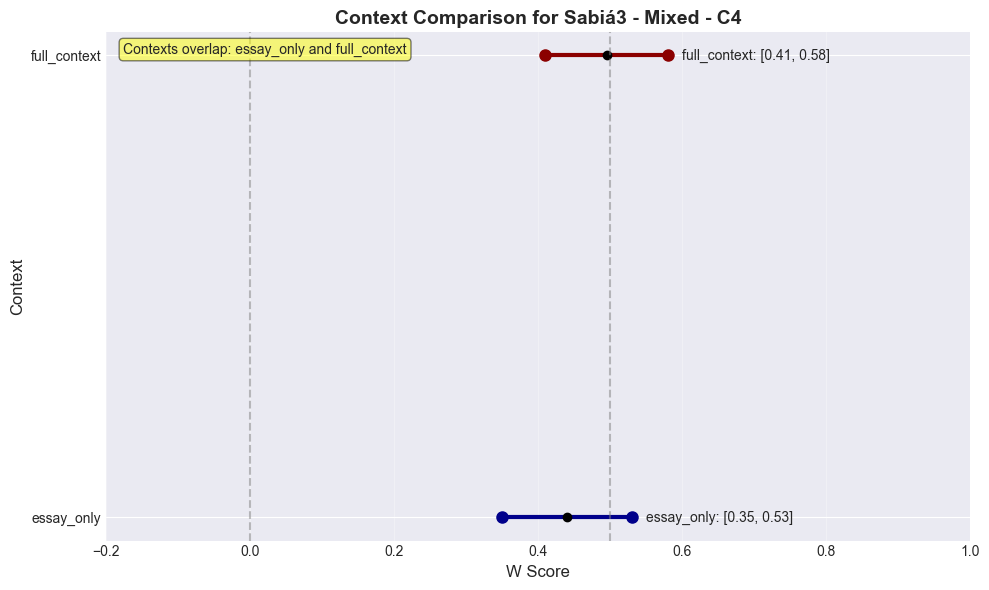

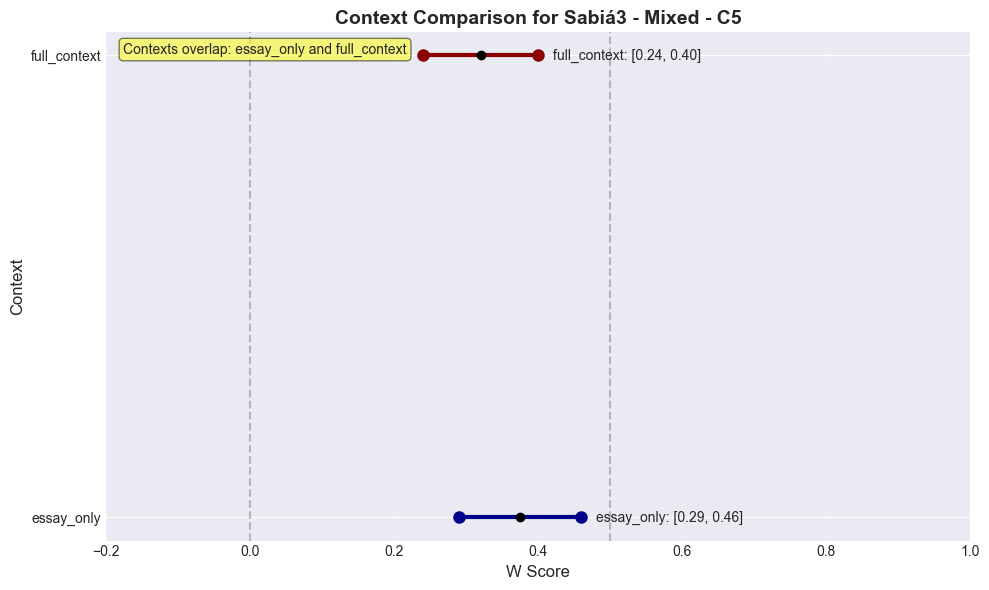


Context Comparison for Model: Sabiá3, Guideline: Student



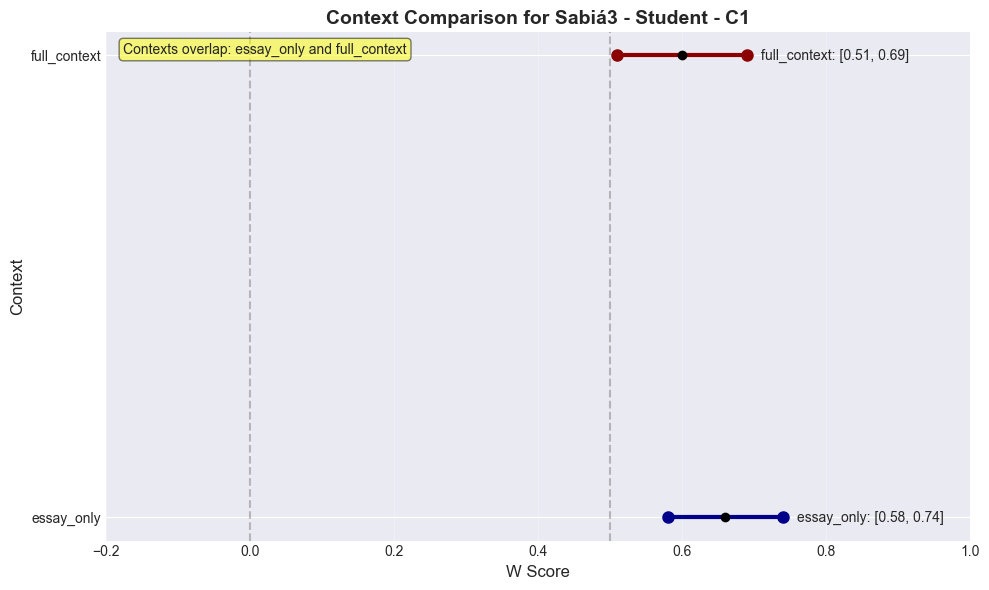

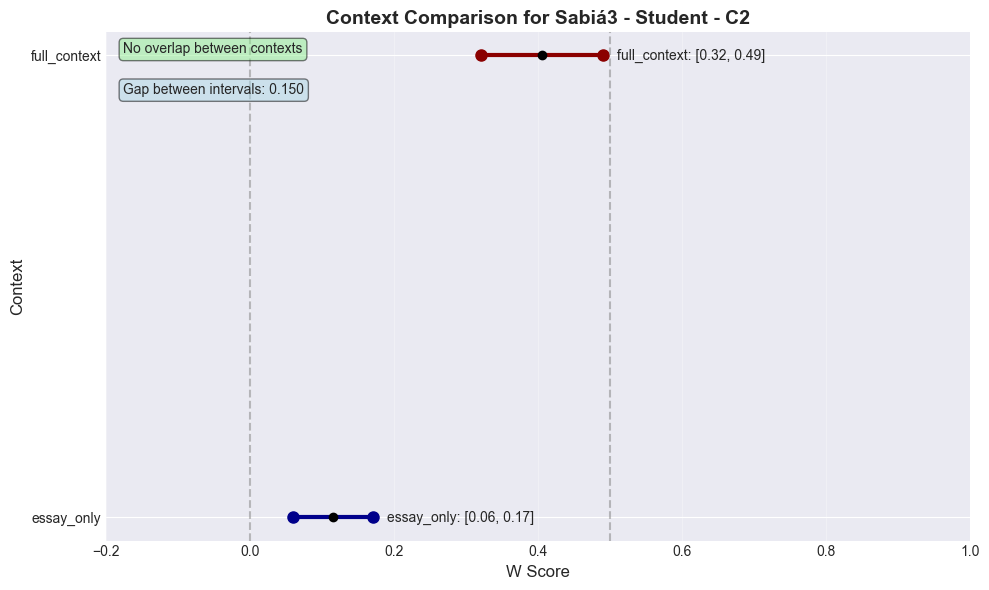

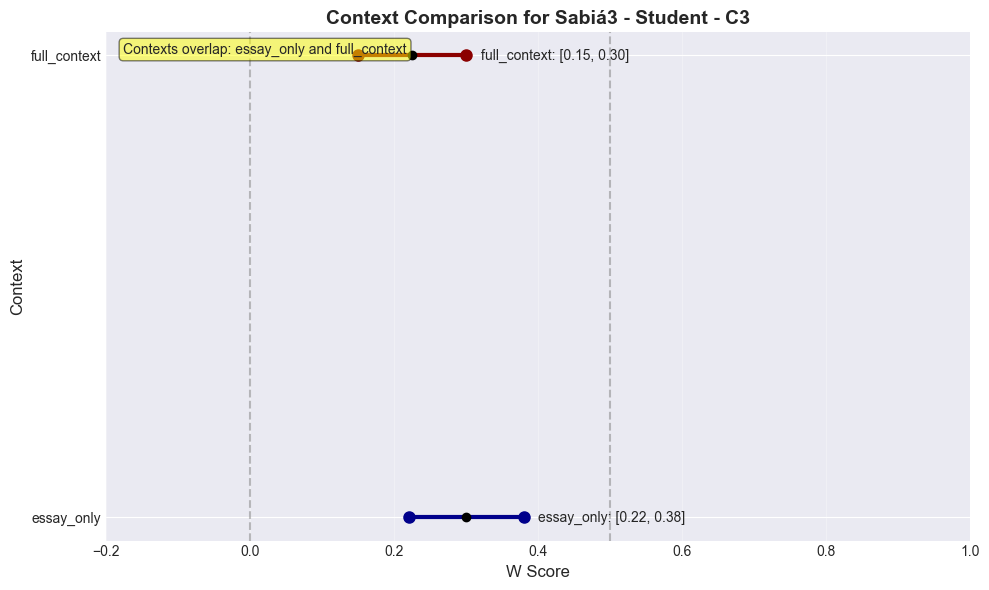

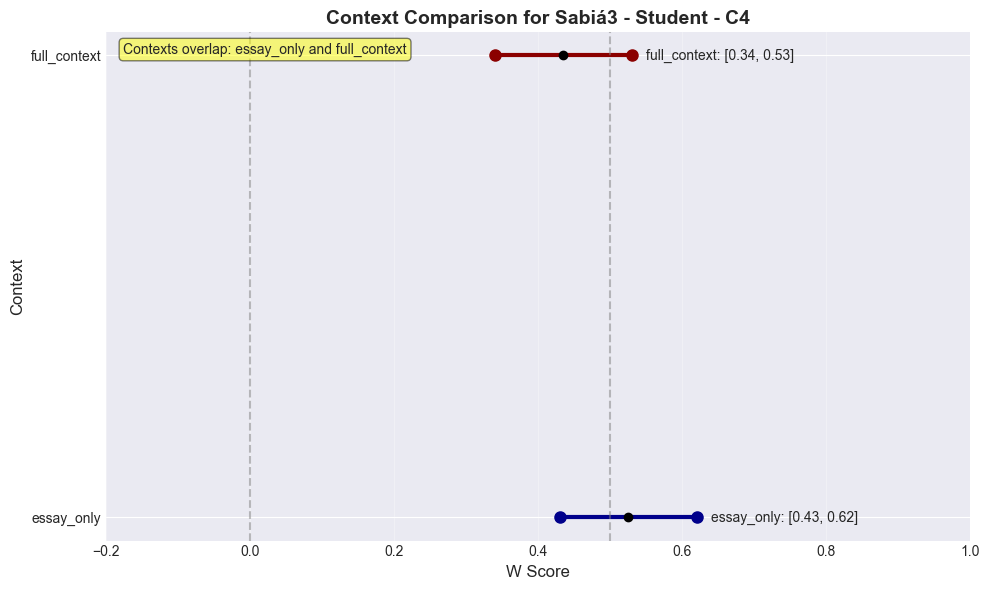

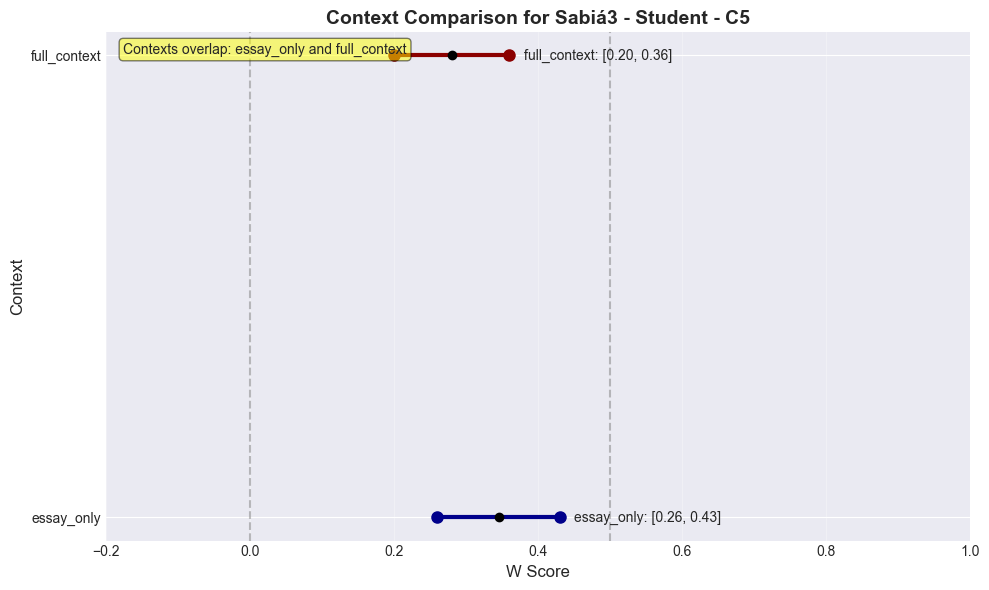


Context Comparison for Model: Sabiá3, Guideline: Grader



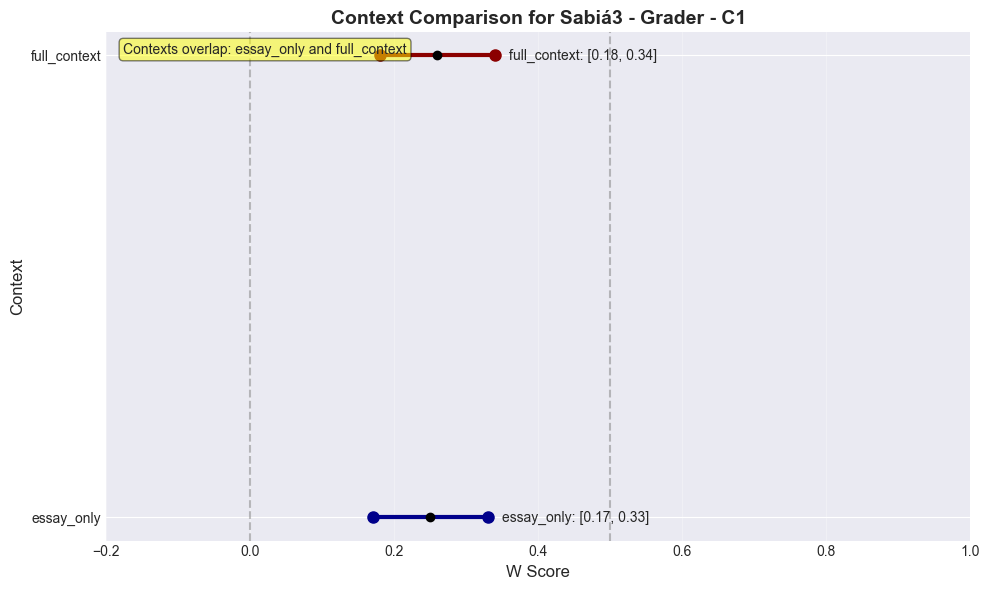

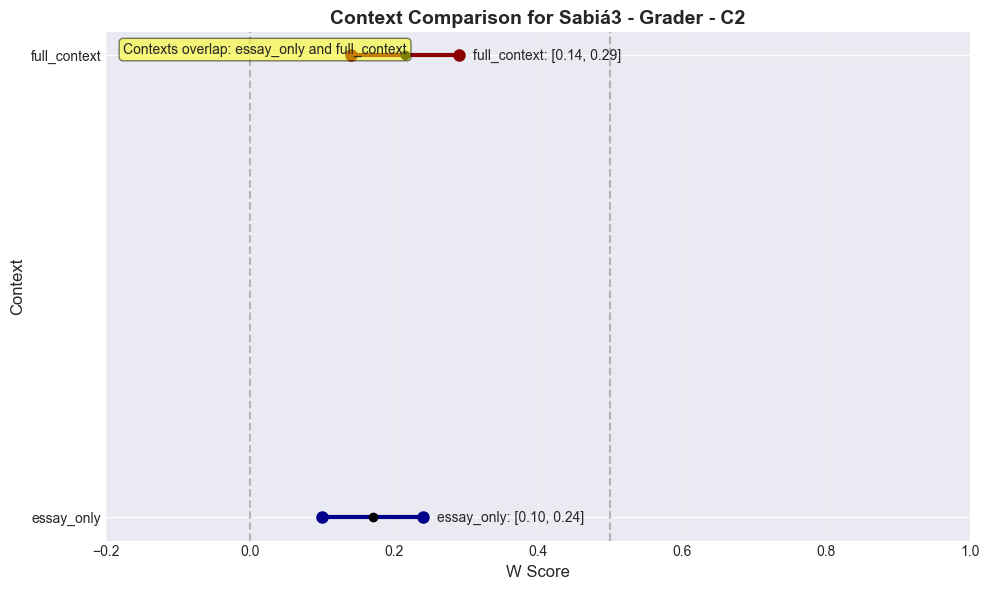

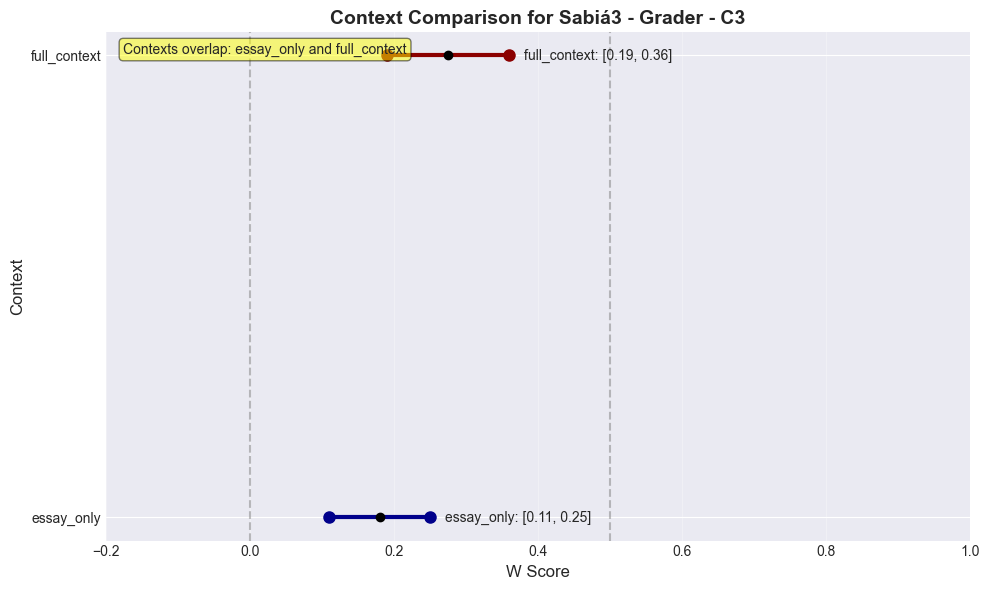

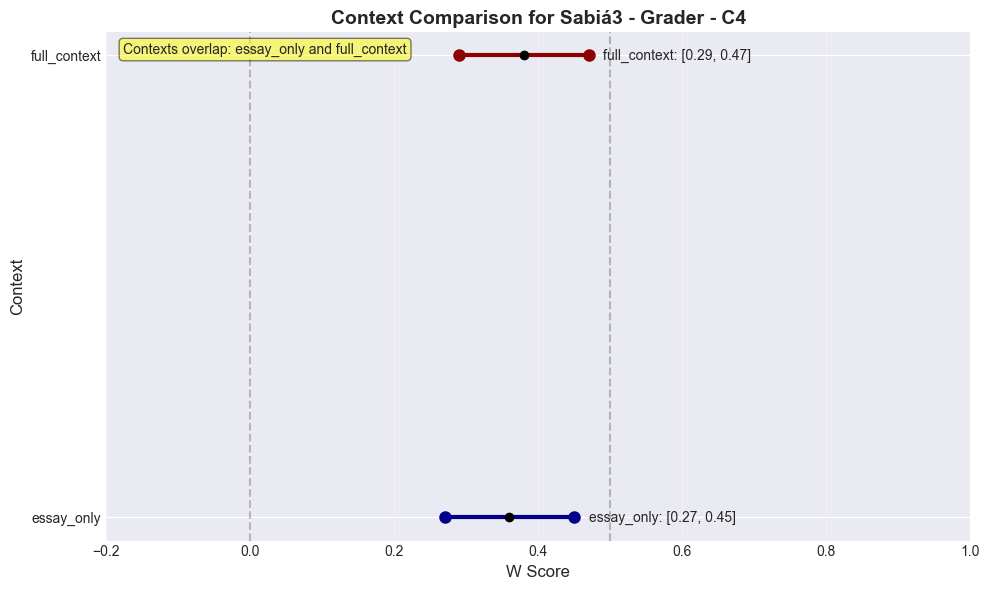

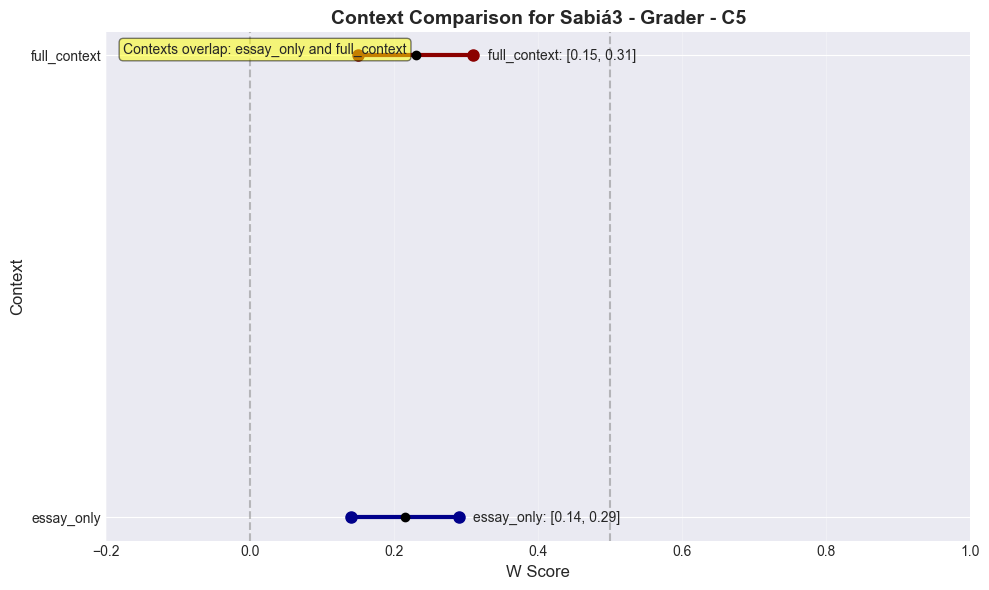

In [10]:
# Analyze all guidelines for a specific model
analyze_all_guidelines_for_model(df, 'Sabiá3', SUFFIX)

## Context Overlap Analysis

This section analyzes whether there are statistical differences between full_context and essay_only for each model-guideline combination.

In [11]:
def create_context_overlap_summary(df, suffix):
    """
    Create a comprehensive visualization showing context overlap for all model-guideline combinations.
    """
    models = df['Model'].unique()
    guidelines = df['Guideline'].unique()
    competencies = ['C1', 'C2', 'C3', 'C4', 'C5']
    
    # Create a figure with subplots for each competency
    fig, axes = plt.subplots(1, 5, figsize=(20, 8))
    
    for idx, comp in enumerate(competencies):
        low_col = f'{comp}_{suffix}_low'
        up_col = f'{comp}_{suffix}_up'
        
        # Create overlap matrix for model-guideline combinations
        overlap_data = []
        y_labels = []
        
        for model in models:
            for guideline in guidelines:
                # Get data for both contexts
                essay_data = df[(df['Model'] == model) & (df['Guideline'] == guideline) & 
                               (df['Context'] == 'essay_only')]
                full_data = df[(df['Model'] == model) & (df['Guideline'] == guideline) & 
                              (df['Context'] == 'full_context')]
                
                if not essay_data.empty and not full_data.empty:
                    # Check if intervals overlap
                    essay_low = essay_data.iloc[0][low_col]
                    essay_up = essay_data.iloc[0][up_col]
                    full_low = full_data.iloc[0][low_col]
                    full_up = full_data.iloc[0][up_col]
                    
                    overlap = (essay_low <= full_up and full_low <= essay_up)
                    overlap_data.append(1 if overlap else 0)
                    y_labels.append(f"{model[:8]}-{guideline[:4]}")
        
        # Convert to matrix (single column since we're comparing 2 contexts)
        overlap_matrix = np.array(overlap_data).reshape(-1, 1)
        
        # Plot heatmap
        ax = axes[idx]
        sns.heatmap(overlap_matrix, 
                    xticklabels=['Context\nOverlap'],
                    yticklabels=y_labels,
                    cmap='RdYlGn_r',
                    vmin=0, vmax=1,
                    cbar=False,
                    ax=ax,
                    annot=False)
        ax.set_title(f'{comp}')
        
    plt.suptitle('Context Overlap Analysis: Essay Only vs Full Context\n(green = no statistical difference between contexts)', 
                 fontsize=16)
    plt.tight_layout()
    plt.show()

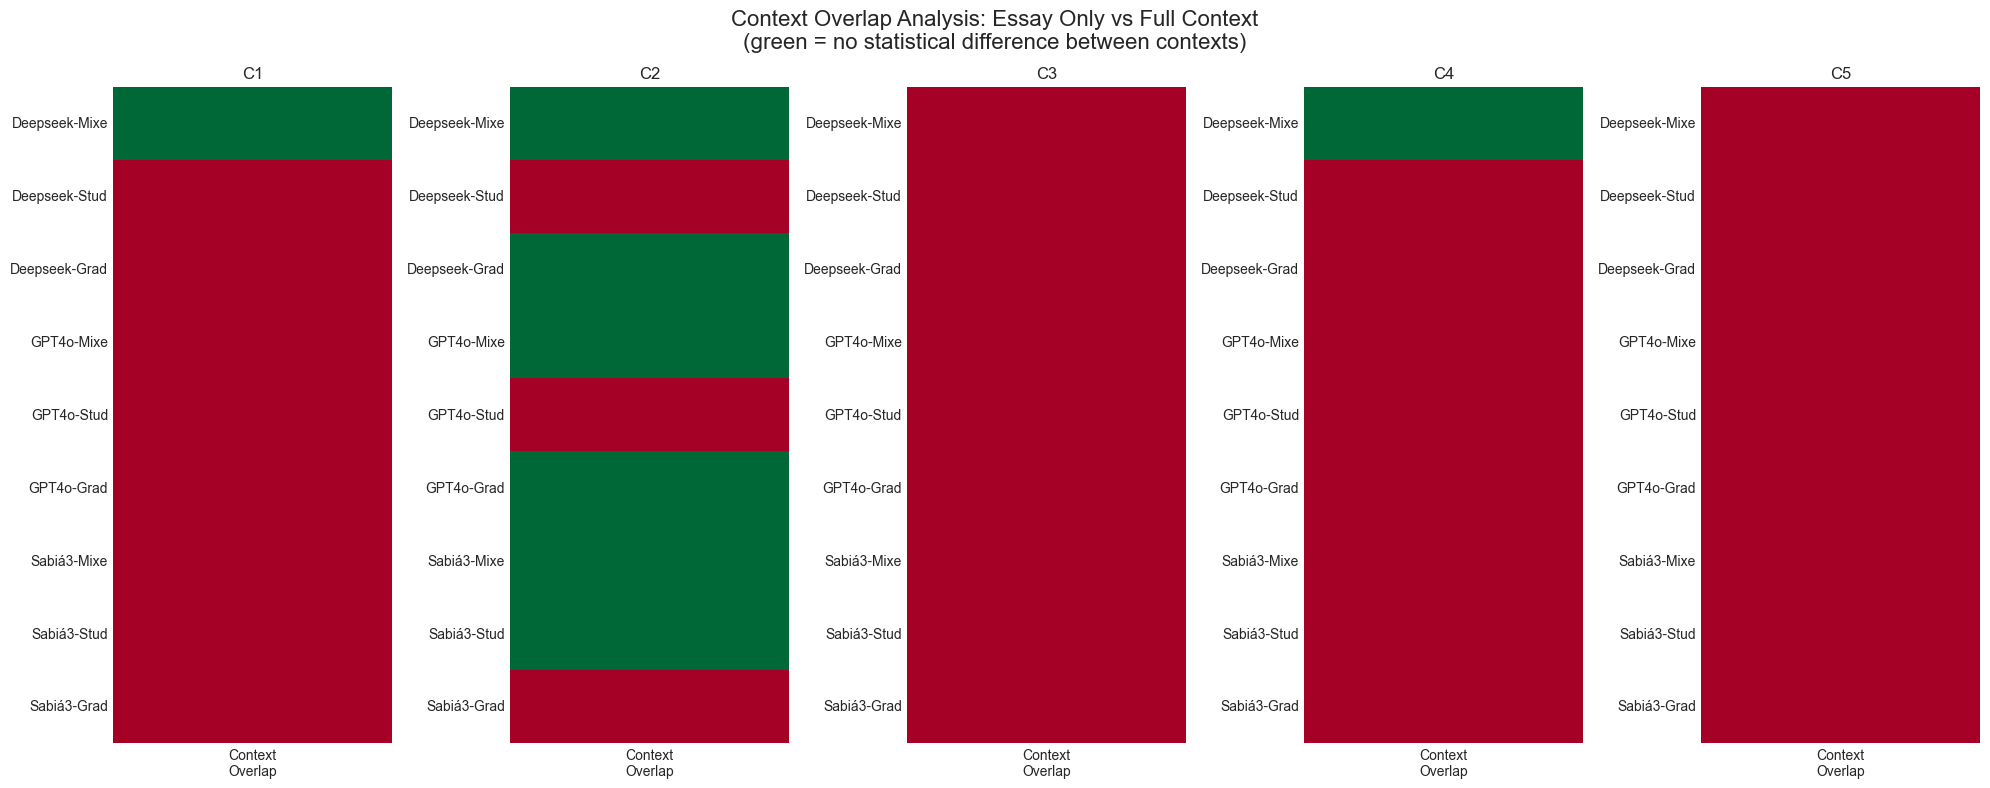

In [12]:
# Create comprehensive context overlap visualization
create_context_overlap_summary(df, SUFFIX)

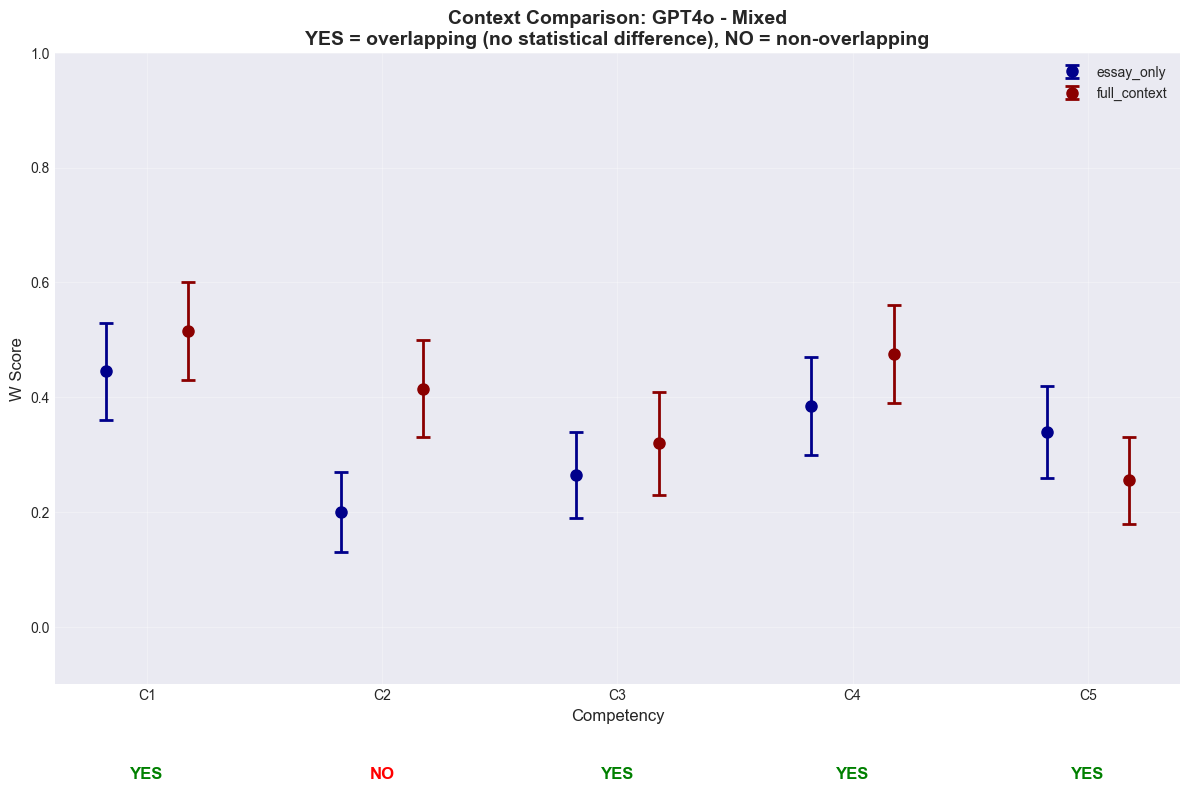

In [15]:
def plot_context_comparison_detailed(df, model_name, guideline_type, suffix):
    """
    Create a detailed comparison of contexts for a specific model and guideline across all competencies.
    """
    # Filter data
    filtered_df = df[(df['Model'] == model_name) & (df['Guideline'] == guideline_type)]
    
    if filtered_df.empty:
        print(f"No data found for model '{model_name}' with guideline '{guideline_type}'")
        return
    
    competencies = ['C1', 'C2', 'C3', 'C4', 'C5']
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Colors for contexts
    colors = {'essay_only': 'darkblue', 'full_context': 'darkred'}
    
    # Plot for each competency
    x_positions = np.arange(len(competencies))
    width = 0.35
    
    for context in ['essay_only', 'full_context']:
        context_data = filtered_df[filtered_df['Context'] == context]
        if not context_data.empty:
            lows = [context_data.iloc[0][f'{comp}_{suffix}_low'] for comp in competencies]
            ups = [context_data.iloc[0][f'{comp}_{suffix}_up'] for comp in competencies]
            mids = [(l + u) / 2 for l, u in zip(lows, ups)]
            errors = [[m - l for m, l in zip(mids, lows)], 
                     [u - m for u, m in zip(ups, mids)]]
            
            offset = -width/2 if context == 'essay_only' else width/2
            ax.errorbar(x_positions + offset, mids, yerr=errors, 
                       fmt='o', capsize=5, capthick=2, 
                       color=colors[context], label=context, 
                       markersize=8, linewidth=2)
    
    # Check overlaps and annotate
    overlap_status = []
    for i, comp in enumerate(competencies):
        essay_data = filtered_df[filtered_df['Context'] == 'essay_only']
        full_data = filtered_df[filtered_df['Context'] == 'full_context']
        
        if not essay_data.empty and not full_data.empty:
            essay_low = essay_data.iloc[0][f'{comp}_{suffix}_low']
            essay_up = essay_data.iloc[0][f'{comp}_{suffix}_up']
            full_low = full_data.iloc[0][f'{comp}_{suffix}_low']
            full_up = full_data.iloc[0][f'{comp}_{suffix}_up']
            
            if essay_low <= full_up and full_low <= essay_up:
                overlap_status.append('YES')
                ax.text(i, -0.15, 'YES', ha='center', color='green', fontsize=12, 
                       weight='bold', transform=ax.get_xaxis_transform())
            else:
                overlap_status.append('NO')
                ax.text(i, -0.15, 'NO', ha='center', color='red', fontsize=12,
                       weight='bold', transform=ax.get_xaxis_transform())
    
    # Customize plot
    ax.set_xticks(x_positions)
    ax.set_xticklabels(competencies)
    ax.set_xlabel('Competency', fontsize=12)
    ax.set_ylabel(f'{suffix} Score', fontsize=12)
    ax.set_title(f'Context Comparison: {model_name} - {guideline_type}\nYES = overlapping (no statistical difference), NO = non-overlapping', 
                fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.0)
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_context_comparison_detailed(df, 'GPT4o', 'Mixed', SUFFIX)

## Statistical Summary: Context Effects

Let's analyze which model-guideline combinations show significant differences between contexts.

Context Effect Summary (Non-overlapping = significant difference between contexts)
     Model Guideline  Non-overlapping  Total  Percentage
DeepseekR1     Mixed                3      5        60.0
DeepseekR1    Grader                1      5        20.0
     GPT4o     Mixed                1      5        20.0
    Sabiá3     Mixed                1      5        20.0
     GPT4o    Grader                1      5        20.0
    Sabiá3   Student                1      5        20.0
DeepseekR1   Student                0      5         0.0
     GPT4o   Student                0      5         0.0
    Sabiá3    Grader                0      5         0.0


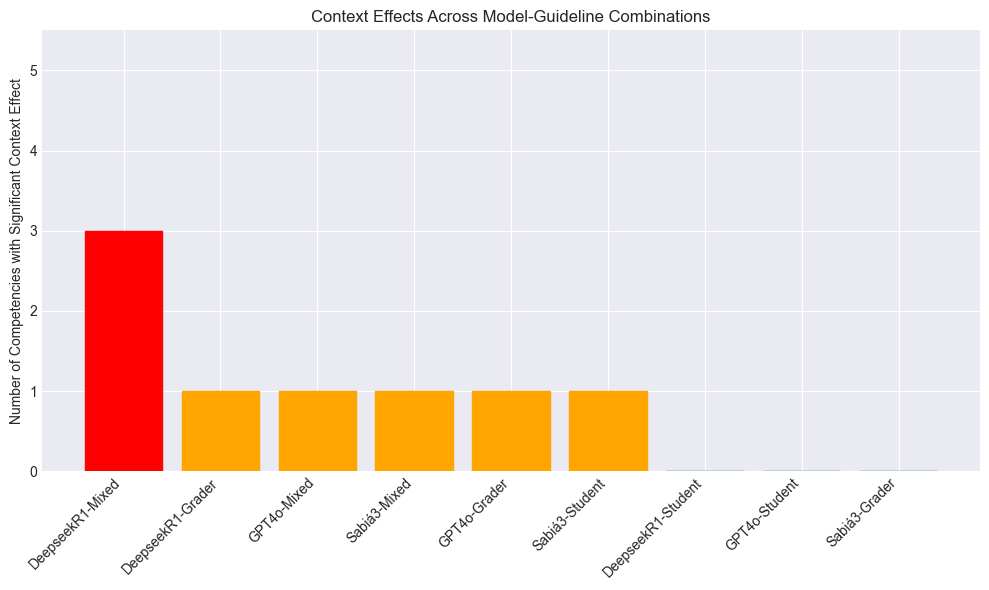

In [14]:
def analyze_context_effects(df, suffix):
    """
    Analyze and summarize which model-guideline combinations show significant context effects.
    """
    models = df['Model'].unique()
    guidelines = df['Guideline'].unique()
    competencies = ['C1', 'C2', 'C3', 'C4', 'C5']
    
    results = []
    
    for model in models:
        for guideline in guidelines:
            # Get data for both contexts
            essay_data = df[(df['Model'] == model) & (df['Guideline'] == guideline) & 
                           (df['Context'] == 'essay_only')]
            full_data = df[(df['Model'] == model) & (df['Guideline'] == guideline) & 
                          (df['Context'] == 'full_context')]
            
            if not essay_data.empty and not full_data.empty:
                overlaps = []
                for comp in competencies:
                    low_col = f'{comp}_{suffix}_low'
                    up_col = f'{comp}_{suffix}_up'
                    
                    essay_low = essay_data.iloc[0][low_col]
                    essay_up = essay_data.iloc[0][up_col]
                    full_low = full_data.iloc[0][low_col]
                    full_up = full_data.iloc[0][up_col]
                    
                    overlap = essay_low <= full_up and full_low <= essay_up
                    overlaps.append(overlap)
                
                # Count non-overlapping competencies
                non_overlapping = sum(1 for o in overlaps if not o)
                results.append({
                    'Model': model,
                    'Guideline': guideline,
                    'Non-overlapping': non_overlapping,
                    'Total': len(competencies),
                    'Percentage': (non_overlapping / len(competencies)) * 100
                })
    
    # Create summary dataframe
    summary_df = pd.DataFrame(results)
    summary_df = summary_df.sort_values('Non-overlapping', ascending=False)
    
    print("Context Effect Summary (Non-overlapping = significant difference between contexts)")
    print("="*70)
    print(summary_df.to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    summary_df['Label'] = summary_df['Model'] + '-' + summary_df['Guideline']
    bars = ax.bar(range(len(summary_df)), summary_df['Non-overlapping'])
    
    # Color bars based on significance
    for i, bar in enumerate(bars):
        if summary_df.iloc[i]['Non-overlapping'] == 0:
            bar.set_color('green')
        elif summary_df.iloc[i]['Non-overlapping'] >= 3:
            bar.set_color('red')
        else:
            bar.set_color('orange')
    
    ax.set_xticks(range(len(summary_df)))
    ax.set_xticklabels(summary_df['Label'], rotation=45, ha='right')
    ax.set_ylabel('Number of Competencies with Significant Context Effect')
    ax.set_title('Context Effects Across Model-Guideline Combinations')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_ylim(0, 5.5)
    
    plt.tight_layout()
    plt.show()

# Analyze context effects
analyze_context_effects(df, SUFFIX)